In [1]:
# import the file and load it in the hypernetwork, load the model, create a batch and test the performance of the mlp
# then the interesting part is the riconstruction of the parameters.

In [1]:
from pathlib import Path
import torch
import control
import numpy as np
import pandas as pdPath
from dataset import WHDataset_Model
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from transformer_sim import Config, TSTransformer, DecoderOnlyInteractionModel
from model import TransformerEncoder, WHModel, Config
import metrics
import matplotlib.colors as colors
import copy
import torch.nn as nn
from torch.func import vmap, grad, functional_call
import time
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE
import math
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [2]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(452)
np.random.seed(55)
system_seed = 66 # Controls the system generation
data_seed = 0 # Controls the input generation

In [3]:
train_val, test = nonlinear_benchmarks.CED()
n = test[0].state_initialization_window_length # = 4
(train_val_u_1, train_val_y_1), (train_val_u_2, train_val_y_2) = train_val
(test_u_1, test_y_1), (test_u_2, test_y_2) = test

# n = test_u_1.state_initialization_window_length

In [4]:
# Overall settings
out_dir_name = "check_WH_over_WH"

# System settings
nu = 1
ny = 1
batch_size = 128
fixed_system = False # Are we testing on a fixed system?

# Compute settings
no_cuda = False
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  =  "cpu"
device = torch.device(device_name)
device_type = 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [5]:
# Create out dir
out_dir = Path(out_dir_name)
#SEED1
exp_data = torch.load(out_dir / "test_WH_lr1e3_nonorm_3mil.pt", map_location=device)
# exp_data = torch.load(out_dir / "ckpt_classic_rmse_2.pt", map_location=device)


cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None


In [6]:
exp_data["iter_num"]

1382000

In [7]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
# model = DecoderOnlyInteractionModel(conf).to(device)
model = TSTransformer(conf).to(device)
model.load_state_dict(exp_data["model"]);
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = torch.tensor(train_val_y_1).unsqueeze(-1).unsqueeze(0)
    batch_u_ctx = torch.tensor(train_val_u_1).unsqueeze(-1).unsqueeze(0)
    batch_y_new = torch.tensor(test_y_1).unsqueeze(-1).unsqueeze(0)
    batch_u_new = torch.tensor(test_u_1).unsqueeze(-1).unsqueeze(0)
    mean_train_u_1, std_train_u_1, mean_train_y_1, std_train_y_1 = batch_u_ctx.mean(),batch_u_ctx.std(),batch_y_ctx.mean(),batch_y_ctx.std()

    batch_y_ctx, batch_u_ctx, batch_u_new, batch_y_new_norm = (batch_y_ctx-mean_train_y_1)/(std_train_y_1+1e-6),(batch_u_ctx-mean_train_u_1)/(std_train_u_1+1e-6),(batch_u_new-mean_train_u_1)/(std_train_u_1+1e-6),(batch_y_new-mean_train_y_1)/(std_train_y_1+1e-6)
    input1 = torch.zeros([1,batch_u_new.shape[1] + cfg.seq_len_n_in-4,1]).float()
    output1 = torch.zeros([1,batch_y_new_norm.shape[1] + cfg.seq_len_n_in-4,1]).float()
    # input2 = torch.zeros([1,test_u_2_norm.shape[1] + cfg.seq_len_n_in-4,1]).float()
    # output2 = torch.zeros([1,test_y_2_norm.shape[1] + cfg.seq_len_n_in-4,1]).float()

    # input1[:,26:,:] = batch_u_new.float()
    # output1[:,26:,:] = batch_y_new_norm.float()
    # # input2[:,26:,:] = test_u_2_norm.float()
    # # output2[:,26:,:] = test_y_2_norm.float()
    # input1[:,:26,:] = batch_u_ctx[:,-26:,:].float()
    # output1[:,:26,:] = batch_y_ctx[:,-26:,:].float()
    # input2[:,:26,:] = train_val_u_2_norm[:,-26:,:].float()
    # output2[:,:26,:] = train_val_y_2_norm[:,-26:,:].float()
    batch_u = torch.cat([batch_u_ctx,batch_u_new], dim = 1)
    batch_y = torch.cat([batch_y_ctx,batch_y_new], dim = 1)
    # print(torch.cat([batch_u_ctx,batch_u_new], dim = 1).shape)
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])

    batch_y_mean,_,_,_,_ = model(batch_y_ctx.float(),batch_u_ctx.float(),batch_u_new.float(),batch_y_new_norm.float(),cfg.seq_len_n_in)
    # batched_wh_simulation = torch.vmap(wh_simulation)
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, batch_u)
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, )
    # print(batch_y_mean.shape)
    # param_list = []
    # for name, param in wh.named_parameters():
        # param_from_hyper = wh_parameters_batch[name]
    #     param_list.append(param_from_hyper.reshape(-1))
    # params_hypernet_vector = torch.cat(param_list)  # shape: (total_num_params,)


NameError: name 'TSTransformer' is not defined

In [ ]:
cfg.seq_len_skip

0

In [7]:
n_hidden = 32
wh = WHModel(cfg.nx,hidden_dim=n_hidden).to(device)
params_WH = dict(wh.named_parameters())
flat_params_WH = nn.utils.parameters_to_vector(wh.parameters())
n_params_WH = flat_params_WH.shape[0]

In [8]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
hypernet = TransformerEncoder(conf).to(device)
# model = TSTransformer_paper(conf).to(device)/
hypernet.load_state_dict(exp_data["model"]);
# cfg.seed +=1

In [9]:
def wh_simulation(params, x):
    y_hat = functional_call(wh, params, x)
    # y_hat = (y_hat-y_hat.mean(axis = 0))/(y_hat.std(axis = 0)+1e-8)

    # params: parameters for a single WH model (dict or OrderedDict)
    # x: input for a single system
    return y_hat

In [10]:
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = torch.tensor(train_val_y_1).unsqueeze(-1).unsqueeze(0)
    batch_u_ctx = torch.tensor(train_val_u_1).unsqueeze(-1).unsqueeze(0)
    batch_y_new = torch.tensor(test_y_1).unsqueeze(-1).unsqueeze(0)
    batch_u_new = torch.tensor(test_u_1).unsqueeze(-1).unsqueeze(0)
    mean_train_u_1, std_train_u_1, mean_train_y_1, std_train_y_1 = batch_u_ctx.mean(),batch_u_ctx.std(),batch_y_ctx.mean(),batch_y_ctx.std()

    batch_y_ctx, batch_u_ctx, batch_u_new, batch_y_new_norm = (batch_y_ctx-mean_train_y_1)/(std_train_y_1+1e-6),(batch_u_ctx-mean_train_u_1)/(std_train_u_1+1e-6),(batch_u_new-mean_train_u_1)/(std_train_u_1+1e-6),(batch_y_new-mean_train_y_1)/(std_train_y_1+1e-6)

    batch_u = torch.cat([batch_u_ctx,batch_u_new], dim = 1)
    batch_y = torch.cat([batch_y_ctx,batch_y_new], dim = 1)
    # print(torch.cat([batch_u_ctx,batch_u_new], dim = 1).shape)
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx)])

    wh_parameters_batch,_,_ = hypernet(batch_u_ctx,batch_y_ctx,wh,0)
    batched_wh_simulation = torch.vmap(wh_simulation)
    batch_y_mean = batched_wh_simulation(wh_parameters_batch, batch_u[:,-150:,:])
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, )
    # print(batch_y_mean.shape)
    # param_list = []
    # for name, param in wh.named_parameters():
        # param_from_hyper = wh_parameters_batch[name]
    #     param_list.append(param_from_hyper.reshape(-1))
    # params_hypernet_vector = torch.cat(param_list)  # shape: (total_num_params,)

In [11]:
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx2 = torch.tensor(train_val_y_2).unsqueeze(-1).unsqueeze(0)
    batch_u_ctx2 = torch.tensor(train_val_u_2).unsqueeze(-1).unsqueeze(0)
    batch_y_new2 = torch.tensor(test_y_2).unsqueeze(-1).unsqueeze(0)
    batch_u_new2 = torch.tensor(test_u_2).unsqueeze(-1).unsqueeze(0)
    mean_train_u_2, std_train_u_2, mean_train_y_2, std_train_y_2 = batch_u_ctx2.mean(),batch_u_ctx2.std(),batch_y_ctx2.mean(),batch_y_ctx2.std()

    batch_y_ctx2, batch_u_ctx2, batch_u_new2, batch_y_new2_norm = (batch_y_ctx2-mean_train_y_2)/(std_train_y_2+1e-6),(batch_u_ctx2-mean_train_u_2)/(std_train_u_2+1e-6),(batch_u_new2-mean_train_u_2)/(std_train_u_2+1e-6),(batch_y_new2-mean_train_y_2)/(std_train_y_2+1e-6)

    batch_u2 = torch.cat([batch_u_ctx2,batch_u_new2], dim = 1)
    batch_y2 = torch.cat([batch_y_ctx2,batch_y_new2], dim = 1)
    # print(torch.cat([batch_u_ctx,batch_u_new], dim = 1).shape)
    batch_y_mean2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx2)])
    batch_y_std2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx2)])

    wh_parameters_batch2,_,_ = hypernet(batch_u_ctx2,batch_y_ctx2,wh,0)
    batched_wh_simulation = torch.vmap(wh_simulation)
    batch_y_mean2 = batched_wh_simulation(wh_parameters_batch2, batch_u2[:,-150:,:])
    # batch_y_mean = batched_wh_simulation(wh_parameters_batch, )
    # print(batch_y_mean.shape)
    # param_list = []
    # for name, param in wh.named_parameters():
        # param_from_hyper = wh_parameters_batch[name]
    #     param_list.append(param_from_hyper.reshape(-1))
    # params_hypernet_vector = torch.cat(param_list)  # shape: (total_num_params,)

In [12]:
print(batch_y_new_norm[:,:,0].mean(),batch_y_new_norm[:,:,0].std())
print(batch_y_new2_norm[:,:,0].mean(),batch_y_new2_norm[:,:,0].std())

tensor(-0.2886, dtype=torch.float64) tensor(0.8516, dtype=torch.float64)
tensor(-0.2398, dtype=torch.float64) tensor(0.7983, dtype=torch.float64)


In [13]:
print(batch_y_mean[:,:,0].mean(),batch_y_mean[:,:,0].std())
print(batch_y_mean2[:,:,0].mean(),batch_y_mean2[:,:,0].std())

tensor(-0.1681, dtype=torch.float64) tensor(0.8574, dtype=torch.float64)
tensor(-0.1303, dtype=torch.float64) tensor(0.8339, dtype=torch.float64)


In [14]:
batch_y_mean = (batch_y_mean[:,-cfg.seq_len_new+n:,:])*std_train_y_1 +mean_train_y_1
batch_y_mean2 = (batch_y_mean2[:,-cfg.seq_len_new+n:,:])*std_train_y_2 +mean_train_y_2
batch_y_mean = (batch_y_mean.to("cpu").detach().numpy())
batch_y_mean2 = (batch_y_mean2.to("cpu").detach().numpy())
# batch_y_norm = (batch_y-batch_y.mean(axis = 1)[:,None])/(batch_y.std(axis = 1)[:,None])
batch_y_new = batch_y.to("cpu").detach().numpy()
batch_y_new2 = batch_y2.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()
batch_u_new2 = batch_u_new2.to("cpu").detach().numpy()

In [15]:
print(batch_y_mean[:,-cfg.seq_len_new+n:,:].mean(),batch_y_mean[:,-cfg.seq_len_new+n:,:].std(),batch_y_new[:,-cfg.seq_len_new+n:,:].mean(),batch_y_new[:,-cfg.seq_len_new+n:,:].std())
print(batch_y_mean2[:,-cfg.seq_len_new+n:,:].mean(),batch_y_mean2[:,-cfg.seq_len_new+n:,:].std(),batch_y_new2[:,-cfg.seq_len_new+n:,:].mean(),batch_y_new2[:,-cfg.seq_len_new+n:,:].std())

0.4032455854251615 0.43393385579222 0.32086894586894577 0.4082081915264539
0.6850011176734355 0.6929643291891477 0.5753968253968252 0.6433538402992954


In [16]:
t = np.arange(1, batch_y_new[:, cfg.seq_len_ctx+n:, 0].shape[1]+1)+cfg.seq_len_n_in + cfg.seq_len_ctx+cfg.seq_len_skip
batch_sim_err = batch_y_new[:, cfg.seq_len_ctx+n:, 0] - batch_y_mean[:,-cfg.seq_len_new+n:,0]
batch_sim_err2 = batch_y_new2[:, cfg.seq_len_ctx+n:, 0] - batch_y_mean2[:,-cfg.seq_len_new+n:,0]

In [17]:
batch_sim_err.shape

(1, 96)

In [18]:
rmse = metrics.rmse_test(batch_y_new[:,-cfg.seq_len_new+n:,:], batch_y_mean[:,-cfg.seq_len_new+n:,:], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new2[:,-cfg.seq_len_new+n:,:], batch_y_mean2[:,-cfg.seq_len_new+n:,:], time_axis=1)
print(f"rmse of CED1: {rmse.mean()}",f"rmse of CED2: {rmse2.mean()}")

rmse of CED1: 0.1636364283305331 rmse of CED2: 0.1901839475171549


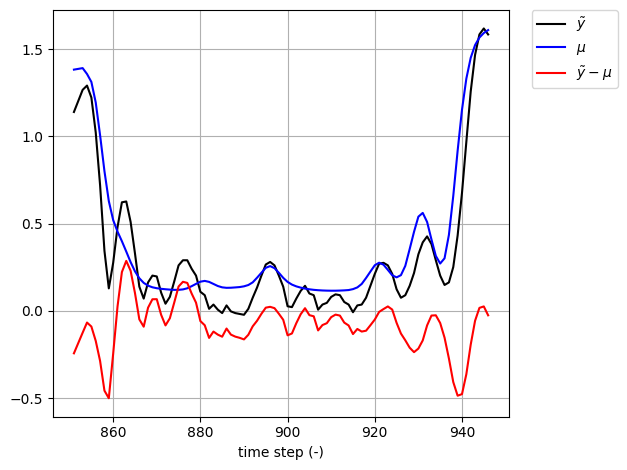

In [19]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 0
plt.plot(t, batch_y_new[idx,-cfg.seq_len_new+n:,:], 'k', label=r"$\tilde y$")
plt.plot(t, batch_y_mean[idx,-cfg.seq_len_new+n:,:], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
plt.plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

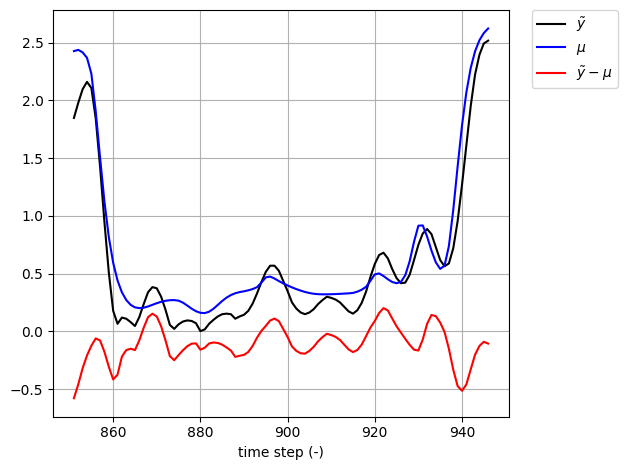

In [20]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 0
plt.plot(t, batch_y_new2[idx,-cfg.seq_len_new+n:,:], 'k', label=r"$\tilde y$")
plt.plot(t, batch_y_mean2[idx,-cfg.seq_len_new+n:,:], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
plt.plot(t, batch_sim_err2[idx, :], 'r', label=r"$\tilde y - \mu$")
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [20]:
rmse[66]

0.2650455234649116

(array([47., 37., 19.,  7.,  7.,  3.,  2.,  3.,  2.,  1.]),
 array([0.05530822, 0.11767582, 0.18004342, 0.24241102, 0.30477862,
        0.36714623, 0.42951383, 0.49188143, 0.55424903, 0.61661663,
        0.67898423]),
 <BarContainer object of 10 artists>)

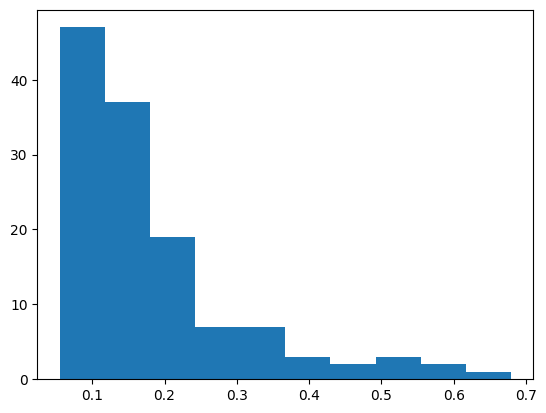

In [27]:
plt.hist(rmse)

(128, 400) (128, 400)


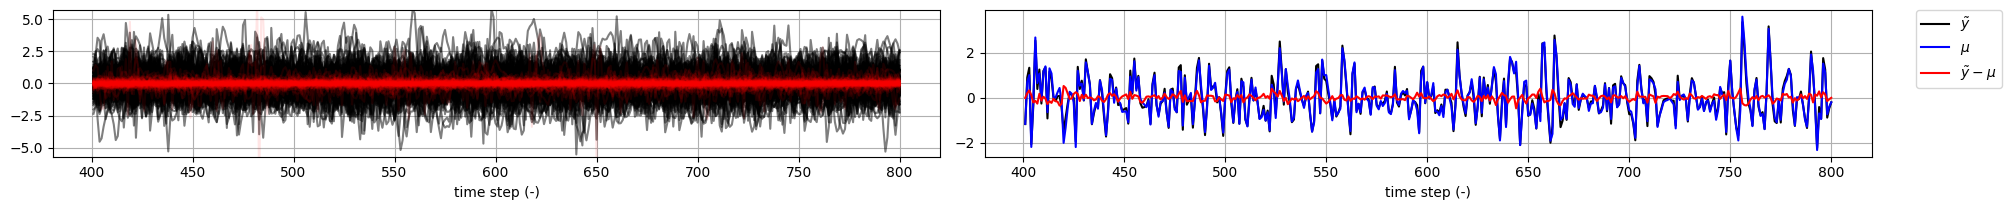

In [17]:
#matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('axes', grid=True)
idx = 20
print(batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_ctx:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,cfg.seq_len_ctx:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [21]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_ctx:, 0], batch_y_mean[:,cfg.seq_len_ctx:,0], time_axis=1)
print(f"rmse of multisine on WH: {rmse.mean()}")

rmse of multisine on WH: 0.2409194372874398


(128, 100) (128, 100)


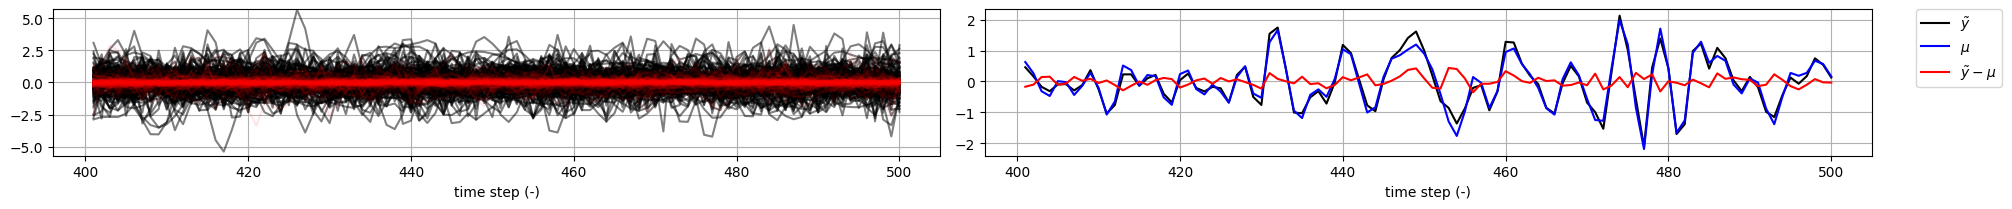

In [22]:
idx = 20
print(batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_ctx:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,cfg.seq_len_ctx:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [14]:
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_ctx:, 0], batch_y_mean[:,cfg.seq_len_ctx:,0], time_axis=1)
print(f"rmse of rbs on WH: {rmse.mean()}")


rmse of rbs on WH: 0.013304765573877131


(128, 100) (128, 100)


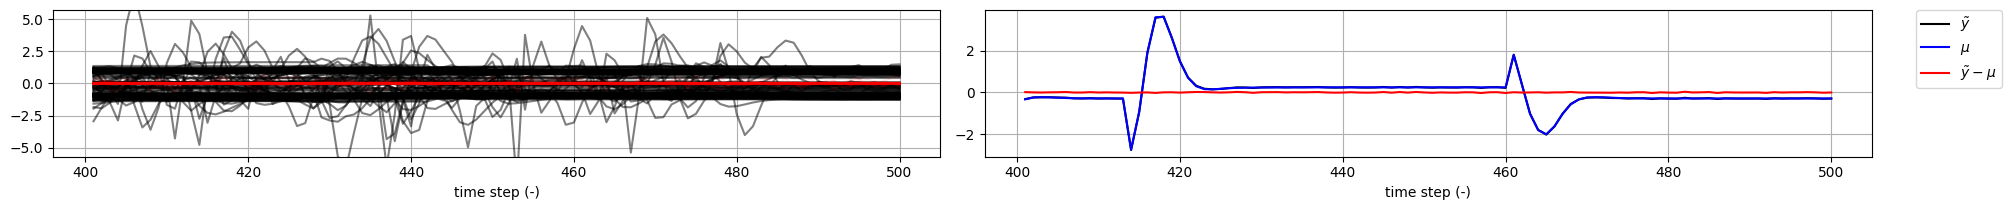

In [15]:
idx = 20
print(batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).shape,batch_sim_err.shape)
fix, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(20, 2.2))
ax[0].plot(t, batch_y_new[:, cfg.seq_len_ctx:, :].squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_sim_err.T, "r", alpha=0.1);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y-\hat y$")
ax[0].set_ylim((-5.7, 5.7))
ax[0].set_xlabel("time step (-)")
ax[0].grid(True)

ax[1].plot(t, batch_y_new[idx, cfg.seq_len_ctx:, 0], 'k', label=r"$\tilde y$")
ax[1].plot(t, batch_y_mean[idx,cfg.seq_len_ctx:, 0], 'b', label="$\mu$")
# ax[1].fill_between(x=t, y1=batch_y_minus[idx, :, 0], y2=batch_y_plus[idx, :, 0], color="blue", alpha=0.2)
ax[1].plot(t, batch_sim_err[idx, :], 'r', label=r"$\tilde y - \mu$")
ax[1].set_xlabel("time step (-)")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
# plt.savefig(fig_path / "wh_sim_batch_single_16000ctx.pdf")
# plt.savefig(fig_path / "wh_sim_batch_single.png")

In [ ]:
for name, param in wh.named_parameters():
    # if name in ['A1','B1','C1','D1']:
    diff = wh_parameters_batch[f'{name}']-params[f'{name}']    
    mean_diff = diff.mean(dim = 0)
    print(mean_diff)
    if 1 in mean_diff.shape:
        diff_np = diff.detach().cpu().numpy()
        batch_size, n, m = diff_np.shape
        if m != 1 and n == 1:
            diff_np = np.moveaxis(diff_np, -1, -2)
            batch_size, n, m = diff_np.shape
        all_errors_abs = np.abs(diff_np).flatten()
        all_errors_abs = all_errors_abs[all_errors_abs > 0]  # filter out zeros to avoid log(0)

        vmin_log = all_errors_abs.min() if len(all_errors_abs) > 0 else epsilon
        vmax_log = all_errors_abs.max()
        norm = mcolors.LogNorm(vmin=vmin_log, vmax=vmax_log)

        cmap = cm.viridis

        # Layout: use up to 6 columns for better visibility
        ncols = min(6, n)
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), constrained_layout=True)
        if nrows == 1:
            axes = np.array([axes])
        axes = axes.flatten()

        epsilon = 1e-10  # small offset for numerical stability in log scale

        for idx in range(n):
            ax = axes[idx]
            errors = np.abs(diff_np)[:, idx]

            # Filter out zeros and negatives (log scale requires > 0)
            if len(errors) == 0:
                # If no positive values, skip plotting this subplot
                ax.axis('off')
                continue

            # Define log spaced bins between min and max positive values
            lower_bound = errors.min()
            upper_bound = errors.max()
            bins = np.logspace(np.log10(lower_bound), np.log10(upper_bound), 21)  # 20 bins

            # Compute histogram with log-spaced bins
            counts, _ = np.histogram(errors, bins=bins)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])

            # Color mapping based on bin centers
            bar_colors = cmap(norm(bin_centers))

            # Plot histogram bars with widths matching log-spaced bin widths
            ax.bar(bin_centers, counts, width=np.diff(bins), color=bar_colors, align='center')

            # Add vertical red line at zero — note zero won't show on log scale
            # You can optionally comment this out as zero is not on log scale
            # ax.axvline(0, color='red', linestyle='--', linewidth=1.5)

            # Set x-axis to log scale
            ax.set_xscale('log')

            ax.set_title(f'Idx {idx}')
            # ax.set_xticks([])
            # ax.set_yticks([])

        # Hide any unused axes
        for ax in axes[n:]:
            ax.axis('off')

        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.02, label='Error Value')

        plt.suptitle(f'Error Distribution per Vector Entry {name} (Logscale x-axis and bins)', fontsize=16)
        plt.show()
        # mean_diff = mean_diff.squeeze(0)
        # mean_diff = mean_diff.flatten()
        # n = mean_diff.shape[0]
        # x = np.arange(n)

        # plt.figure(figsize=(8, 2))
        # sc = plt.scatter(x, mean_diff, c=mean_diff, cmap='winter', s=100)  # main scatter plot
        # plt.colorbar(sc, label='Mean Difference')
        # plt.xlabel('Bias Index')
        # plt.ylabel('Mean Difference')
        # plt.title(f'Average Bias Difference {name} (Green=Low, Blue=High)')

        # # Overlay red circles for values near zero
        # if [1] != list(mean_diff.shape):
        #     threshold = 0.5  # adjust as needed for "near zero"
        #     near_zero_mask = np.abs(mean_diff) < threshold
        #     plt.scatter(x[near_zero_mask], mean_diff[near_zero_mask],
        #                 facecolors='none', edgecolors='red', s=150, linewidths=2, label='Near Zero')

        # plt.legend(loc='upper right')
        # plt.show()
    
    else:
        diff_np = diff.detach().cpu().numpy()
        batch_size, rows, cols = diff_np.shape
        
        # vmin = np.percentile(diff_np, 1)
        # vmax = np.percentile(diff_np, 99)
        # # vmin, vmax = diff_np.min(), diff_np.max()
        # norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        # cmap = cm.viridis

        # fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
        # axes = axes.flatten()

        # for i in range(rows):
        #     for j in range(cols):
        #         ax = axes[i * cols + j]
        #         errors = diff_np[:, i, j]

        #         # Remove outliers: keep only between 5th and 95th percentiles
        #         lower_bound = np.percentile(errors, 1)
        #         upper_bound = np.percentile(errors, 99)
        #         errors_filtered = errors[(errors >= lower_bound) & (errors <= upper_bound)]

        #         # Compute histogram on filtered data
        #         counts, bins = np.histogram(errors_filtered, bins=30)
        #         bin_centers = 0.5 * (bins[:-1] + bins[1:])
        #         colors = cmap(norm(bin_centers))
                
        #         ax.bar(bin_centers, counts, width=(bins[1] - bins[0]), color=colors, align='center')
        #         ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
        #         ax.set_title(f'Elem ({i},{j})')
        #         ax.set_xticks([])
        #         ax.set_yticks([])

        epsilon = 1e-10

        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), constrained_layout=True)
        axes = axes.flatten()

        cmap = cm.viridis

        # We will normalize on absolute bin centers, avoiding zero or negative values for LogNorm
        all_errors_abs = np.abs(diff_np).flatten()
        all_errors_abs = all_errors_abs[all_errors_abs > 0]  # filter out zeros to avoid log(0)

        vmin_log = np.percentile(all_errors_abs, 1) if len(all_errors_abs) > 0 else epsilon
        vmax_log = np.percentile(all_errors_abs, 99)

        norm = mcolors.LogNorm(vmin=vmin_log, vmax=vmax_log)
  
        for i in range(rows):
            for j in range(cols):
                ax = axes[i * cols + j]
                errors = np.abs(diff_np)[:, i, j]
                lower_bound = np.percentile(errors, 1)
                upper_bound = np.percentile(errors, 99)
                errors_filtered = errors[(errors >= lower_bound) & (errors <= upper_bound)]

                # Create logarithmically spaced bins between lower_bound and upper_bound
                bins = np.logspace(np.log10(lower_bound), np.log10(upper_bound), 51)  # 50 bins
                counts, _ = np.histogram(errors_filtered, bins=bins)

                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                # Use a colormap or single color, for example:
                colors = cmap(norm(bin_centers))

                ax.bar(bin_centers, counts, width=np.diff(bins), color=colors, align='center')
                # Optional: vertical line at zero (but zero won't be shown in log scale)
                # ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
                ax.set_xscale('log')
                ax.set_title(f'Elem ({i},{j})')
                # ax.set_xticks([])
                # ax.set_yticks([])

        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.02, label='Absolute Error Value (log scale)')

        plt.suptitle(f'Error Distribution for Each Parameter Element {name} (Outliers Removed)', fontsize=16)
        plt.show()


        # plt.figure(figsize=(6, 5))
        # plt.imshow(mean_diff, cmap='winter')
        # plt.colorbar(label='Mean Difference')
        # plt.title('Average Difference (Green=Low, Blue=High, Red=Near Zero)')
        # plt.xlabel('Column')
        # plt.ylabel('Row')

        # # Overlay red circles for values below a threshold
        # threshold = 0.5  # Define what "near zero" means for you
        # y_idx, x_idx = np.where(np.abs(mean_diff) < threshold)
        # plt.scatter(x_idx, y_idx, facecolors='none', edgecolors='red', s=100, linewidths=0.6, label='Near Zero')

        # plt.legend(loc='upper right')
        # plt.show()
